In [1]:
# Packages laden
import pandas as pd
import numpy as np
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.backend import binary_crossentropy
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True,)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
ZR = ZR.reshape((len(ZR), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ZR)
ZR_N = scaler.transform(ZR)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]

# Anteil der Datensätze am Gesamtdatensatz: normalisierte Daten
ZR_N100=ZR_N
ZR_N46=ZR_N[-400:]

In [6]:
# Preprocessing der Rohdaten: 100%
ZR_100new=np.atleast_2d(ZR_N100)
if ZR_100new.shape[0]==1:
    ZR_100new=ZR_100new.T
nb_samples_100, nb_series_100 = ZR_100new.shape

In [7]:
# Preprocessing der Rohdaten: 46%
ZR_46new=np.atleast_2d(ZR_N46)
if ZR_46new.shape[0]==1:
    ZR_46new=ZR_46new.T
nb_samples_46, nb_series_46 = ZR_46new.shape

In [9]:
# Einteilung in Trainings- und Testdaten:normalisierte Daten
test_size_100=int(0.3*nb_samples_100)
train_100, test_100 = ZR_N100[:-test_size_100], ZR_N100[-test_size_100:] 

test_size_46=int(0.35*nb_samples_46)
train_46, test_46 = ZR_N46[:-test_size_46], ZR_N46[-test_size_46:]

In [10]:
# Einteilung in Trainings- und Testdaten:originale Daten
train_100_O, test_100_O = ZR_100[:-test_size_100], ZR_100[-test_size_100:] 

train_46_O, test_46_O = ZR_46[:-test_size_46], ZR_46[-test_size_46:]

In [11]:
# Shape des Input und Outputs anpassen: 100%
look_forward=60
window_size=12
# Trainingsdaten
Xtrain_100=np.atleast_3d(np.array([train_100[start:start+window_size] for start in range(0, train_100.shape[0]-(window_size+look_forward))]))
ytrain_100=train_100[window_size+look_forward:]
qtrain_100=np.atleast_3d([train_100[-(window_size):]])
print(qtrain_100.shape, ytrain_100.shape, Xtrain_100.shape)

# Testdaten
Xtest_100=np.atleast_3d(np.array([test_100[start:start+window_size] for start in range(0, test_100.shape[0]-(window_size+look_forward))]))
ytest_100=test_100[window_size+look_forward:]
qtest_100=np.atleast_3d([test_100[-(window_size):]])
print(qtest_100.shape, ytest_100.shape, Xtest_100.shape)

(1, 12, 1) (533, 1) (533, 12, 1)
(1, 12, 1) (186, 1) (186, 12, 1)


In [12]:
# Shape des Input und Outputs anpassen: 46%
# Trainingsdaten
Xtrain_46=np.atleast_3d(np.array([train_46[start:start+window_size] for start in range(0, train_46.shape[0]-(window_size+look_forward))]))
ytrain_46=train_46[window_size+look_forward:]
qtrain_46=np.atleast_3d([train_46[-(window_size):]])
print(qtrain_46.shape, ytrain_46.shape, Xtrain_46.shape)

# Testdaten
Xtest_46=np.atleast_3d(np.array([test_46[start:start+window_size] for start in range(0, test_46.shape[0]-(window_size+look_forward))]))
ytest_46=test_46[window_size+look_forward:]
qtest_46=np.atleast_3d([test_46[-(window_size):]])
print(qtest_46.shape, ytest_46.shape, Xtest_46.shape)

(1, 12, 1) (188, 1) (188, 12, 1)
(1, 12, 1) (68, 1) (68, 12, 1)


In [13]:
ytrain_100_O=train_100_O[window_size+look_forward:]
ytest_100_O=test_100_O[window_size+look_forward:]

ytrain_46_O=train_46_O[window_size+look_forward:]
ytest_46_O=test_46_O[window_size+look_forward:]

In [14]:
# Modell zusammenbauen: 
nb_filter_1=32
nb_filter_2=64
nb_filter_3=64
filter_length=2
nb_input_series=1
nb_outputs=1
model= Sequential()
model.add(Convolution1D(nb_filter=nb_filter_1, filter_length=filter_length, activation='sigmoid', 
                        input_shape=(window_size, nb_input_series)))
model.add(Convolution1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='sigmoid'))
model.add(MaxPooling1D())
model.add(Convolution1D(nb_filter=nb_filter_3, filter_length=filter_length, activation='sigmoid'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(nb_outputs, activation='linear')) 
model.compile(loss='mse', optimizer='adam', metrics=['mae']) 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="sigmoid", input_shape=(12, 1), filters=32, kernel_size=2)`
  # Remove the CWD from sys.path while we load stuff.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="sigmoid", filters=64, kernel_size=2)`
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="sigmoid", filters=64, kernel_size=2)`
  del sys.path[0]


In [15]:
# Modellzusammenfassung
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 11, 32)            96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 64)            4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 64)             8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

In [55]:
# Replizierbarkeit gewährleisten
np.random.seed(8)

In [56]:
# Modellanpassen: 100%
history_reg=model.fit(Xtrain_100, ytrain_100, epochs=200, batch_size=25, validation_data=(Xtest_100, ytest_100))

Train on 533 samples, validate on 186 samples
Epoch 1/200
533/533 [==============================] - 0s 400us/step - loss: 0.0195 - mean_absolute_error: 0.1014 - val_loss: 0.0387 - val_mean_absolute_error: 0.1863
Epoch 2/200
533/533 [==============================] - 0s 430us/step - loss: 0.0189 - mean_absolute_error: 0.0996 - val_loss: 0.0377 - val_mean_absolute_error: 0.1836
Epoch 3/200
533/533 [==============================] - 0s 403us/step - loss: 0.0190 - mean_absolute_error: 0.1000 - val_loss: 0.0368 - val_mean_absolute_error: 0.1811
Epoch 4/200
533/533 [==============================] - 0s 368us/step - loss: 0.0194 - mean_absolute_error: 0.0994 - val_loss: 0.0373 - val_mean_absolute_error: 0.1827
Epoch 5/200
533/533 [==============================] - 0s 392us/step - loss: 0.0196 - mean_absolute_error: 0.1009 - val_loss: 0.0372 - val_mean_absolute_error: 0.1822
Epoch 6/200
533/533 [==============================] - 0s 356us/step - loss: 0.0191 - mean_absolute_error: 0.1009 - val

Epoch 98/200
533/533 [==============================] - 0s 428us/step - loss: 0.0195 - mean_absolute_error: 0.0979 - val_loss: 0.0404 - val_mean_absolute_error: 0.1908
Epoch 99/200
533/533 [==============================] - 0s 347us/step - loss: 0.0189 - mean_absolute_error: 0.0998 - val_loss: 0.0366 - val_mean_absolute_error: 0.1805
Epoch 100/200
533/533 [==============================] - 0s 398us/step - loss: 0.0182 - mean_absolute_error: 0.0967 - val_loss: 0.0374 - val_mean_absolute_error: 0.1829
Epoch 101/200
533/533 [==============================] - 0s 413us/step - loss: 0.0190 - mean_absolute_error: 0.0988 - val_loss: 0.0394 - val_mean_absolute_error: 0.1882
Epoch 102/200
533/533 [==============================] - 0s 396us/step - loss: 0.0195 - mean_absolute_error: 0.1003 - val_loss: 0.0368 - val_mean_absolute_error: 0.1811
Epoch 103/200
533/533 [==============================] - 0s 396us/step - loss: 0.0190 - mean_absolute_error: 0.0981 - val_loss: 0.0385 - val_mean_absolute_er

533/533 [==============================] - 0s 403us/step - loss: 0.0191 - mean_absolute_error: 0.0996 - val_loss: 0.0335 - val_mean_absolute_error: 0.1720
Epoch 195/200
533/533 [==============================] - 0s 394us/step - loss: 0.0184 - mean_absolute_error: 0.0967 - val_loss: 0.0358 - val_mean_absolute_error: 0.1785
Epoch 196/200
533/533 [==============================] - 0s 435us/step - loss: 0.0186 - mean_absolute_error: 0.1001 - val_loss: 0.0365 - val_mean_absolute_error: 0.1802
Epoch 197/200
533/533 [==============================] - 0s 401us/step - loss: 0.0186 - mean_absolute_error: 0.0995 - val_loss: 0.0362 - val_mean_absolute_error: 0.1795
Epoch 198/200
533/533 [==============================] - 0s 390us/step - loss: 0.0187 - mean_absolute_error: 0.0993 - val_loss: 0.0359 - val_mean_absolute_error: 0.1788
Epoch 199/200
533/533 [==============================] - 0s 411us/step - loss: 0.0190 - mean_absolute_error: 0.0985 - val_loss: 0.0360 - val_mean_absolute_error: 0.1789


Text(0.5,1,'Loss Curves')

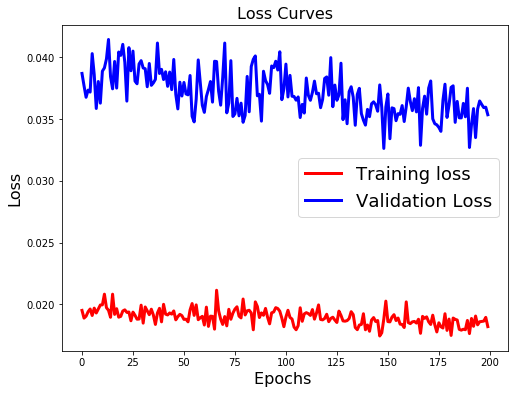

In [57]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

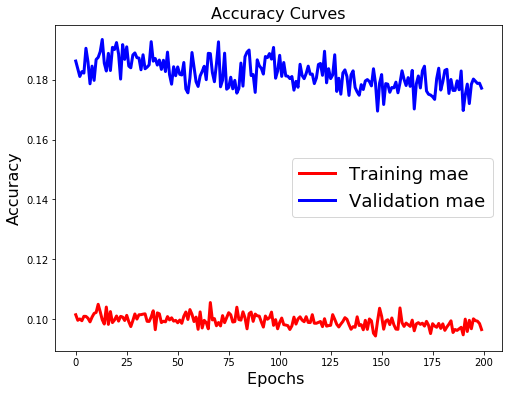

In [58]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [59]:
# Vorhersage generieren
predictions_100N = model.predict(Xtest_100)
predictions_train_100N=model.predict(Xtrain_100)

# Prediction Denormalizing
testPredict_100=scaler.inverse_transform(predictions_100N)
trainPredict_100=scaler.inverse_transform(predictions_train_100N)

In [60]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_100_O, testPredict_100)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_100_O, trainPredict_100)
print('Train MSE: %.3f' % mse_train)

Test MSE: 207979053.149
Train MSE: 101993693.582


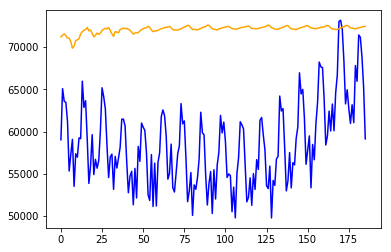

In [61]:
# Gegenüberstellung von Vorhersage und Testdaten
plt.plot(ytest_100_O, color='blue') 
plt.plot(testPredict_100, color='orange') 
plt.show()

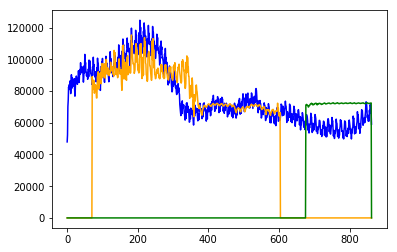

In [62]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_100))
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(window_size+look_forward-1):len(trainPredict_100)+(window_size+look_forward-1)] = trainPredict_100


# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot=testPredictPlot.reshape(len(ZR_100))
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(trainPredict_100)+2*(window_size+look_forward)-1:len(ZR_100)-1] = testPredict_100
     
       
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [87]:
# Replizierbarkeit gewährleisten
np.random.seed(4)

In [88]:
# Modellanpassen: 46%
history_reg=model.fit(Xtrain_46, ytrain_46, epochs=200, batch_size=25, validation_data=(Xtest_46, ytest_46))

Train on 188 samples, validate on 68 samples
Epoch 1/200
188/188 [==============================] - 0s 526us/step - loss: 0.0036 - mean_absolute_error: 0.0477 - val_loss: 0.0223 - val_mean_absolute_error: 0.1279
Epoch 2/200
188/188 [==============================] - 0s 431us/step - loss: 0.0036 - mean_absolute_error: 0.0487 - val_loss: 0.0206 - val_mean_absolute_error: 0.1217
Epoch 3/200
188/188 [==============================] - 0s 457us/step - loss: 0.0034 - mean_absolute_error: 0.0465 - val_loss: 0.0230 - val_mean_absolute_error: 0.1301
Epoch 4/200
188/188 [==============================] - 0s 638us/step - loss: 0.0034 - mean_absolute_error: 0.0465 - val_loss: 0.0214 - val_mean_absolute_error: 0.1245
Epoch 5/200
188/188 [==============================] - 0s 495us/step - loss: 0.0033 - mean_absolute_error: 0.0451 - val_loss: 0.0243 - val_mean_absolute_error: 0.1350
Epoch 6/200
188/188 [==============================] - 0s 436us/step - loss: 0.0038 - mean_absolute_error: 0.0497 - val_

188/188 [==============================] - 0s 431us/step - loss: 0.0036 - mean_absolute_error: 0.0489 - val_loss: 0.0154 - val_mean_absolute_error: 0.1026
Epoch 98/200
188/188 [==============================] - 0s 420us/step - loss: 0.0032 - mean_absolute_error: 0.0451 - val_loss: 0.0172 - val_mean_absolute_error: 0.1098
Epoch 99/200
188/188 [==============================] - 0s 484us/step - loss: 0.0035 - mean_absolute_error: 0.0467 - val_loss: 0.0160 - val_mean_absolute_error: 0.1050
Epoch 100/200
188/188 [==============================] - 0s 500us/step - loss: 0.0034 - mean_absolute_error: 0.0461 - val_loss: 0.0165 - val_mean_absolute_error: 0.1074
Epoch 101/200
188/188 [==============================] - 0s 457us/step - loss: 0.0033 - mean_absolute_error: 0.0459 - val_loss: 0.0163 - val_mean_absolute_error: 0.1062
Epoch 102/200
188/188 [==============================] - 0s 580us/step - loss: 0.0032 - mean_absolute_error: 0.0451 - val_loss: 0.0173 - val_mean_absolute_error: 0.1105
Ep

188/188 [==============================] - 0s 431us/step - loss: 0.0030 - mean_absolute_error: 0.0436 - val_loss: 0.0100 - val_mean_absolute_error: 0.0797
Epoch 194/200
188/188 [==============================] - 0s 441us/step - loss: 0.0030 - mean_absolute_error: 0.0441 - val_loss: 0.0098 - val_mean_absolute_error: 0.0787
Epoch 195/200
188/188 [==============================] - 0s 505us/step - loss: 0.0033 - mean_absolute_error: 0.0460 - val_loss: 0.0100 - val_mean_absolute_error: 0.0796
Epoch 196/200
188/188 [==============================] - 0s 495us/step - loss: 0.0030 - mean_absolute_error: 0.0443 - val_loss: 0.0091 - val_mean_absolute_error: 0.0748
Epoch 197/200
188/188 [==============================] - 0s 441us/step - loss: 0.0030 - mean_absolute_error: 0.0429 - val_loss: 0.0094 - val_mean_absolute_error: 0.0762
Epoch 198/200
188/188 [==============================] - 0s 436us/step - loss: 0.0032 - mean_absolute_error: 0.0453 - val_loss: 0.0089 - val_mean_absolute_error: 0.0737


Text(0.5,1,'Loss Curves')

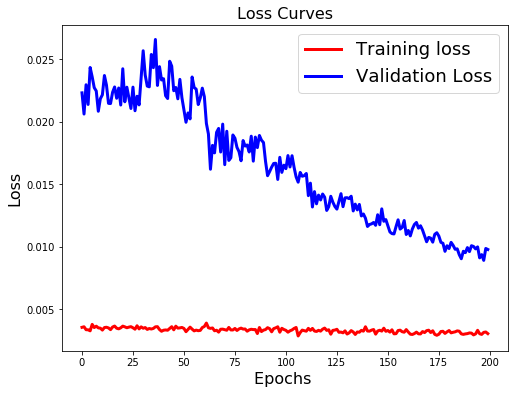

In [89]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

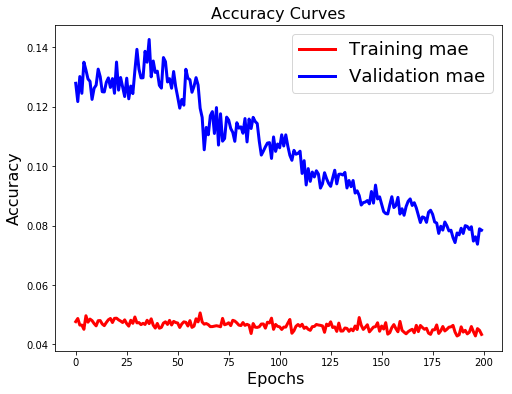

In [90]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [91]:
# Vorhersage generieren
predictions_46N = model.predict(Xtest_46)
predictions_train_46N=model.predict(Xtrain_46)

# Prediction Denormalizing
testPredict_46=scaler.inverse_transform(predictions_46N)
trainPredict_46=scaler.inverse_transform(predictions_train_46N)

In [92]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_46_O, testPredict_46)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_46_O, trainPredict_46)
print('Train MSE: %.3f' % mse_train)

Test MSE: 57582824.029
Train MSE: 16424136.931


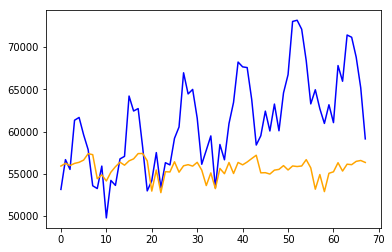

In [93]:
# Gegenüberstellung von Vorhersage und Testdaten
plt.plot(ytest_46_O, color='blue') 
plt.plot(testPredict_46, color='orange') 
plt.show()

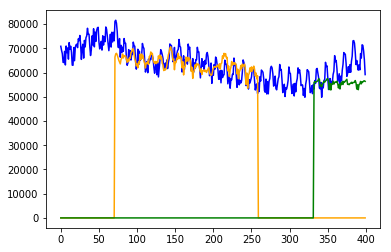

In [94]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_46))
trainPredictPlot[:]=[0]*len(ZR_46)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_46),1)
trainPredictPlot[(window_size+look_forward-1):len(trainPredict_46)+(window_size+look_forward-1)] = trainPredict_46


# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot=testPredictPlot.reshape(len(ZR_46))
testPredictPlot[:]=[0]*len(ZR_46)
testPredictPlot = testPredictPlot.reshape(len(ZR_46),1)
testPredictPlot[len(trainPredict_46)+2*(window_size+look_forward):len(ZR_100)-1] = testPredict_46
     
       
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()